In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Datasets.

In [4]:
feature_names = ['TC_COMPRESSOR_STATE', 
                 'TC_UPPER_SOURCE_PUMP_STATE',
                 'WORK_TIMER', 
                 'TC_CURRENT_FLOW',
                 'TC_CURRENT_POWER_CONSUMPTION',
                 'TC_COMPRESSOR_OIL_TEMP',
                 'TC_EVD_CONDENSING_PRESSURE']

path = '../data_for_models/data.csv'
df = pd.read_csv(path)
df = df[feature_names]
print("Database: {}".format(df.shape))
# df = df.dropna()
df = df.fillna(method='ffill')
print("Database after fill nan: {}".format(df.shape))

df['WORK_TIMER'] = df.TC_COMPRESSOR_STATE * df.TC_COMPRESSOR_LAST_WORK_TIME

Database: (225676, 7)
Database after fill nan: (225676, 7)


### Train and test dataset.

In [5]:
train_dataset = df[feature_names].sample(frac=0.8,random_state=0)
test_dataset = df[feature_names].drop(train_dataset.index)

train_y = train_dataset.pop('TC_EVD_CONDENSING_PRESSURE')
test_y = test_dataset.pop('TC_EVD_CONDENSING_PRESSURE')

### Normalization.

In [6]:
def normalization(data, columns):
    scaler = MinMaxScaler()
    for col in columns:
        norm = scaler.fit_transform(data[col].values.reshape(-1, 1))
        data[col] = norm
    return data
        
train_dataset = normalization(train_dataset, ['TC_COMPRESSOR_STATE',
                                              'TC_UPPER_SOURCE_PUMP_STATE',
                                              'TC_CURRENT_FLOW',
                                              'TC_CURRENT_POWER_CONSUMPTION',
                                              'WORK_TIMER',
                                              'TC_COMPRESSOR_OIL_TEMP'
                                             ])
test_dataset = normalization(test_dataset, ['TC_COMPRESSOR_STATE', 
                                            'TC_UPPER_SOURCE_PUMP_STATE',
                                            'TC_CURRENT_FLOW',
                                            'TC_CURRENT_POWER_CONSUMPTION',
                                            'WORK_TIMER',
                                            'TC_COMPRESSOR_OIL_TEMP'
                                           ])

### Model

In [7]:
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(train_dataset.columns)]),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

# optimizer = Adam(learning_rate=0.001, beta_1 = 0.9, beta_2=0.999, amsgrad=False)
optimizer = RMSprop(learning_rate=0.005, rho=0.9)
model.compile(loss='mse', optimizer=optimizer, metrics =[metrics.mae])
model.summary()

W0121 12:16:39.369774 139635328649024 deprecation.py:506] From /home/marcin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

### Train

In [8]:
epochs = 10
history = model.fit(train_dataset, 
                    train_y, 
                    epochs=epochs, 
                    validation_split=0.3, 
                    verbose=1, 
                    batch_size=64)

Train on 126378 samples, validate on 54163 samples
Epoch 1/10
126378/126378 [==============================] - 12s 95us/sample - loss: 4276.9704 - mean_absolute_error: 53.1022 - val_loss: 1359.7401 - val_mean_absolute_error: 32.5164
Epoch 2/10
126378/126378 [==============================] - 11s 87us/sample - loss: 2889.6929 - mean_absolute_error: 43.2172 - val_loss: 1133.2330 - val_mean_absolute_error: 29.3480
Epoch 3/10
126378/126378 [==============================] - 11s 86us/sample - loss: 2462.1161 - mean_absolute_error: 39.8696 - val_loss: 1050.7369 - val_mean_absolute_error: 28.0558
Epoch 4/10
126378/126378 [==============================] - 12s 93us/sample - loss: 2178.8430 - mean_absolute_error: 37.6210 - val_loss: 976.9309 - val_mean_absolute_error: 26.7460
Epoch 5/10
126378/126378 [==============================] - 11s 87us/sample - loss: 1935.4018 - mean_absolute_error: 35.4830 - val_loss: 1128.8057 - val_mean_absolute_error: 29.3444
Epoch 6/10
126378/126378 [==============

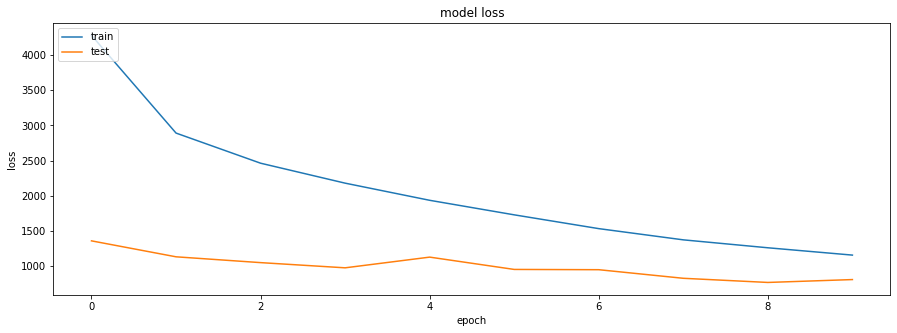

In [9]:
# summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
y_pred = model.predict(test_dataset)
y_true = np.reshape(test_y.values, (y_pred.shape[0],1))

acc = np.abs(y_pred - y_true).mean()
acc

20.419710459212098

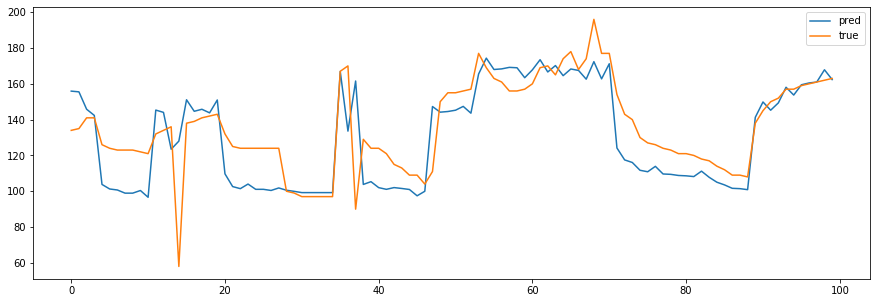

In [16]:
x = list(range(100))
plt.figure(figsize=(15,5))
plt.plot(x, y_pred[100:200], '-', label='pred')
plt.plot(x, y_true[100:200], '-', label='true')
plt.legend()
plt.show()